# Set up some data generating process

In [1]:
from numpy.random import poisson, normal, choice
import torch
import matplotlib.pyplot as plt

def sample_polynomial(lengthscale):
    order = poisson(2)
    bias = normal(0, 1)
    return [normal(0, lengthscale**(-d)) for d in range(0, order+1)]

def eval_polynomial(weights, X):
    return sum(w*X**d for d, w in enumerate(weights))

def add_noise(sigma, Y):
    return Y + torch.randn_like(Y)*sigma

def generate_data():
    lengthscale = 10
    max_context = 30
    max_target = 50
    noise_std = 0.01
    def unit_to_interval(X):
        return (X-0.5)*2*lengthscale
    polynomial = sample_polynomial(lengthscale)
    def get_samples(polynomial, max_n):
        n = choice(range(1, max_n))
        X = unit_to_interval(torch.rand(n))
        Y = add_noise(noise_std, eval_polynomial(polynomial, X))
        return X, Y
    X_context, Y_context = get_samples(polynomial, max_context)
    X_target, Y_target = get_samples(polynomial, max_target)
    return [xy.unsqueeze(-1) for xy in [X_context, Y_context, X_target, Y_target]]

def generate_batch(batch_size):
    batches = [], [], [], []
    for _ in range(batch_size):
        result = generate_data()
        for T, t in zip(batches, result):
            T.append(t)
    return batches  # we do not stack into tensor as they have variable length

n_plots = 6
fig, axes = plt.subplots(ncols=n_plots, figsize=(16, 3))
X, Y, _, _ = generate_batch(n_plots)
for i, (x, y) in enumerate(zip(X, Y)):
    x = x.view(-1).numpy()
    y = y.view(-1).numpy()
    axes[i].scatter(x, y)

tensor(6580.1748, grad_fn=<AddBackward0>)


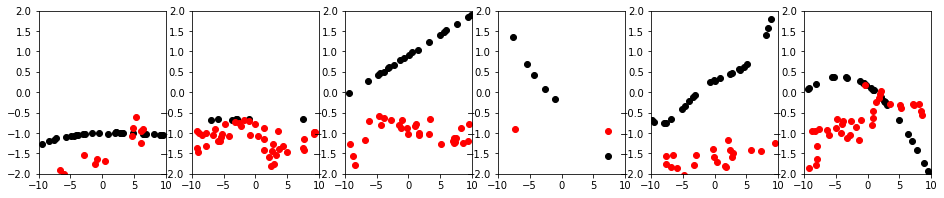

tensor(2280.5701, grad_fn=<AddBackward0>)


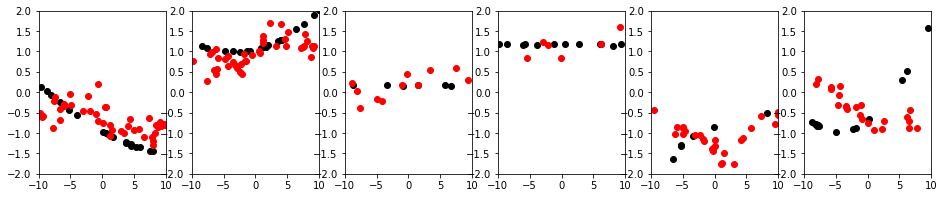

tensor(1793.5713, grad_fn=<AddBackward0>)


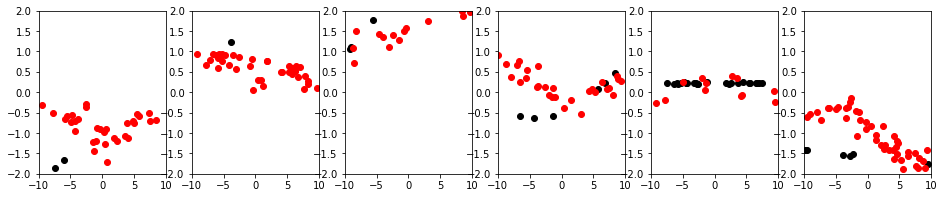

tensor(1689.3641, grad_fn=<AddBackward0>)


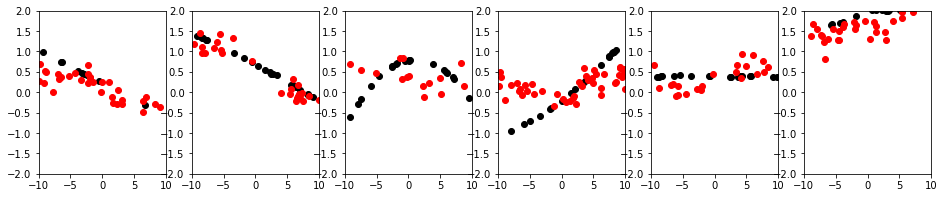

tensor(1787.5244, grad_fn=<AddBackward0>)


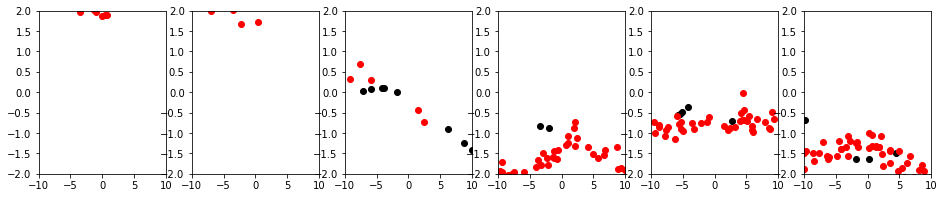

tensor(1748.0632, grad_fn=<AddBackward0>)


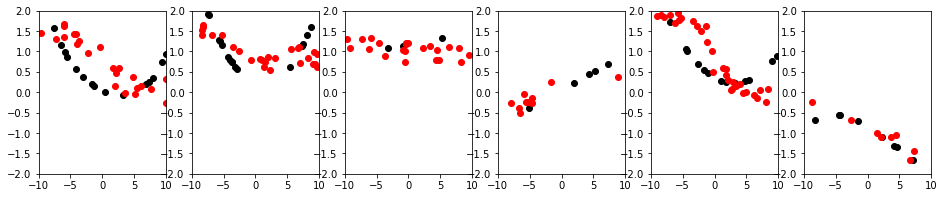

tensor(1571.1415, grad_fn=<AddBackward0>)


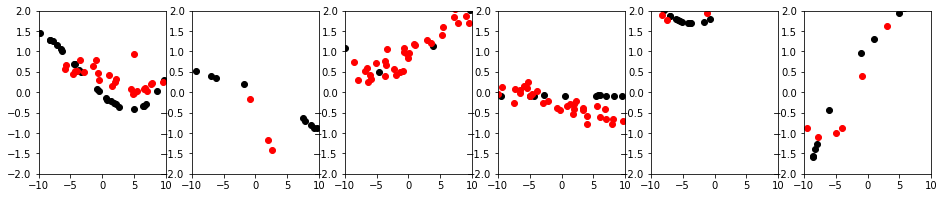

tensor(1488.9596, grad_fn=<AddBackward0>)


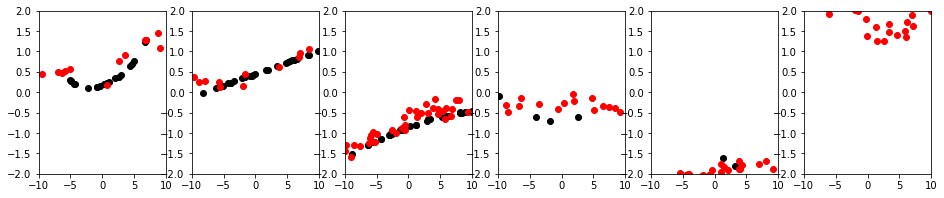

tensor(1888.8855, grad_fn=<AddBackward0>)


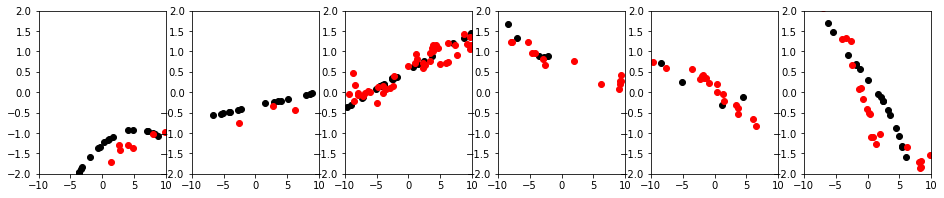

tensor(1565.8981, grad_fn=<AddBackward0>)


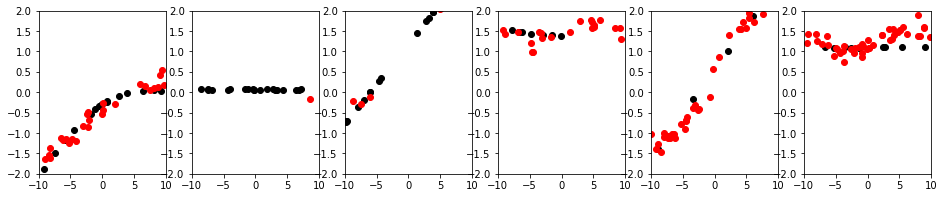

tensor(1675.9862, grad_fn=<AddBackward0>)


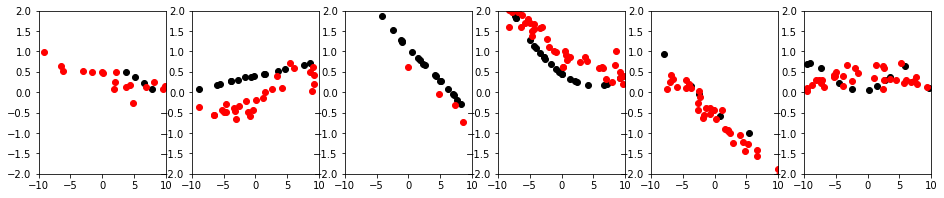

tensor(1534.5831, grad_fn=<AddBackward0>)


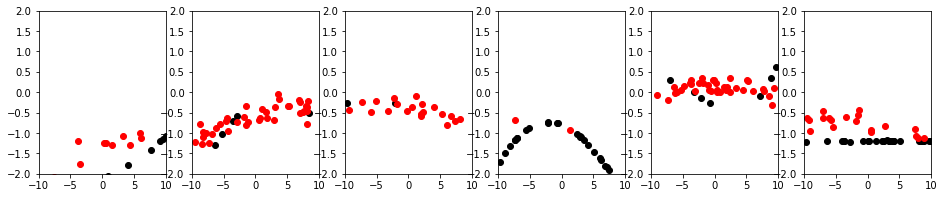

tensor(1578.7374, grad_fn=<AddBackward0>)


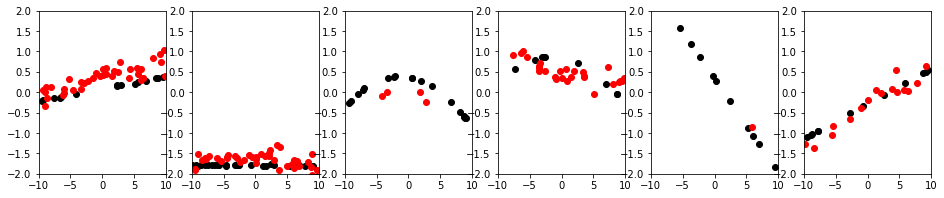

tensor(1439.6223, grad_fn=<AddBackward0>)


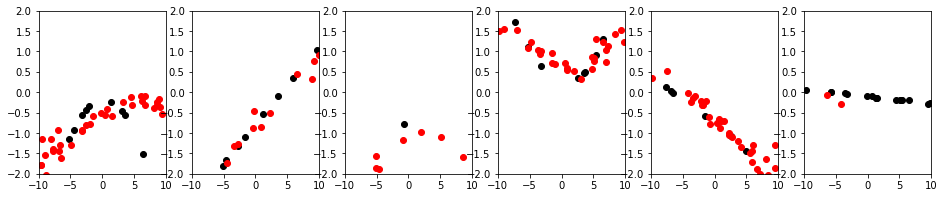

tensor(1622.5194, grad_fn=<AddBackward0>)


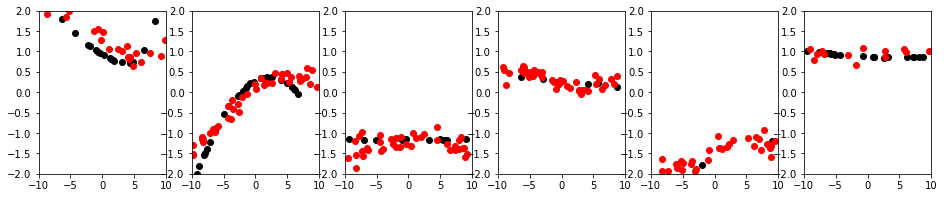

tensor(1534.6262, grad_fn=<AddBackward0>)


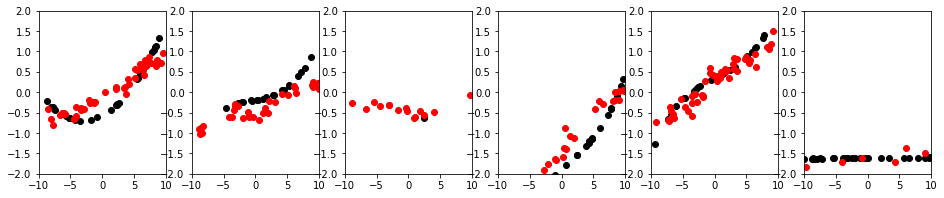

tensor(1568.0452, grad_fn=<AddBackward0>)


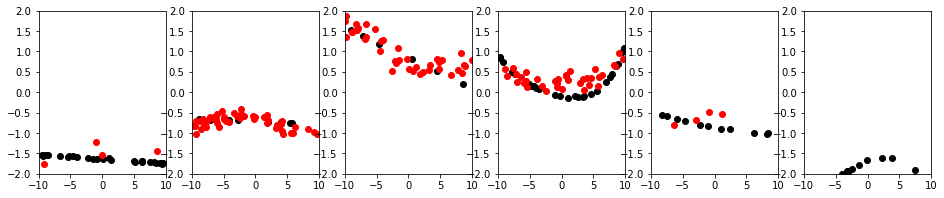

tensor(1467.0472, grad_fn=<AddBackward0>)


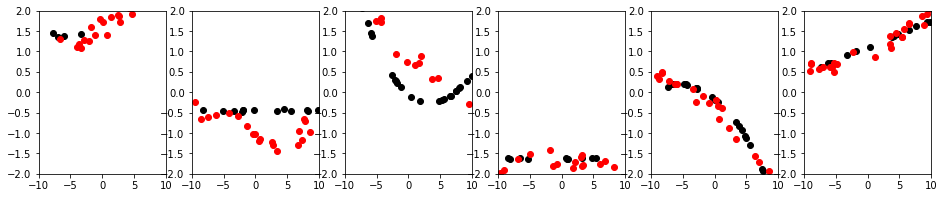

tensor(1479.4913, grad_fn=<AddBackward0>)


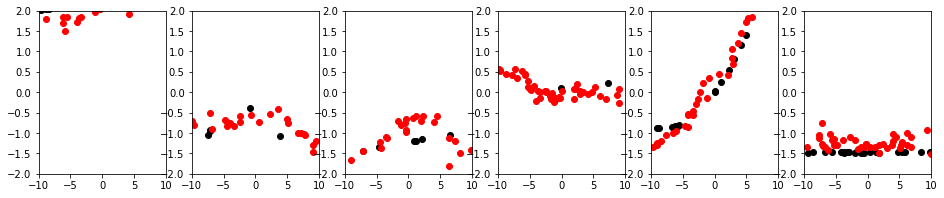

tensor(1498.4485, grad_fn=<AddBackward0>)


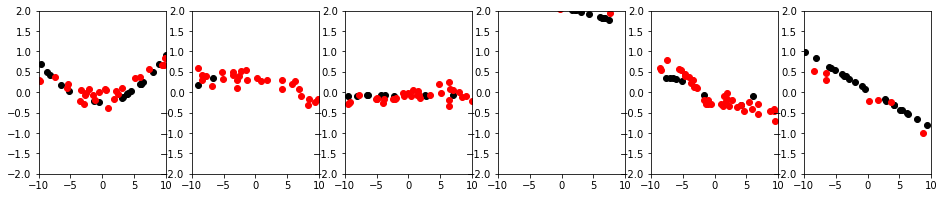

tensor(1492.2976, grad_fn=<AddBackward0>)


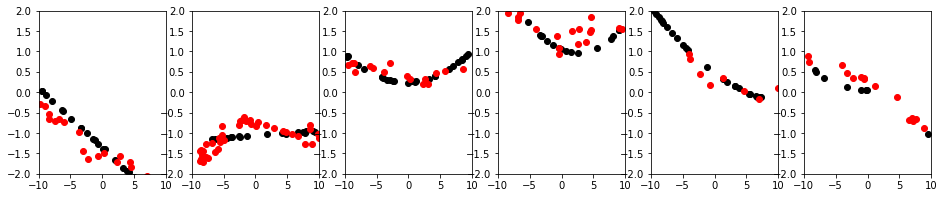

tensor(1514.4126, grad_fn=<AddBackward0>)


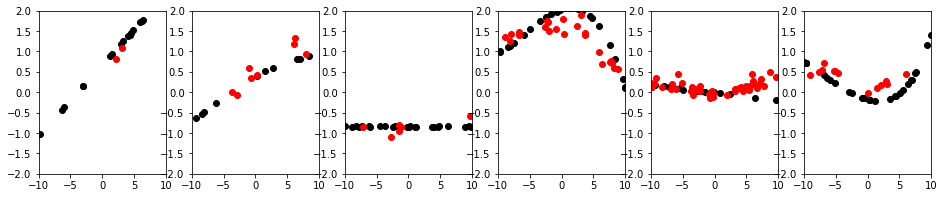

tensor(1324.9534, grad_fn=<AddBackward0>)


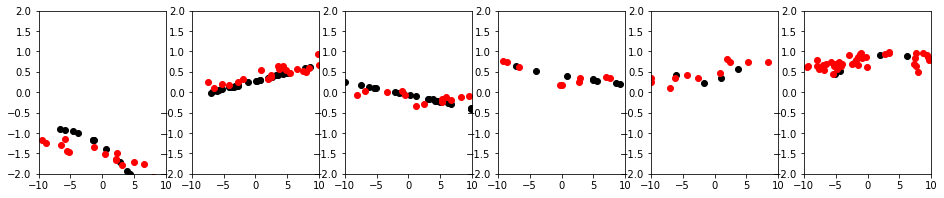

tensor(1534.3777, grad_fn=<AddBackward0>)


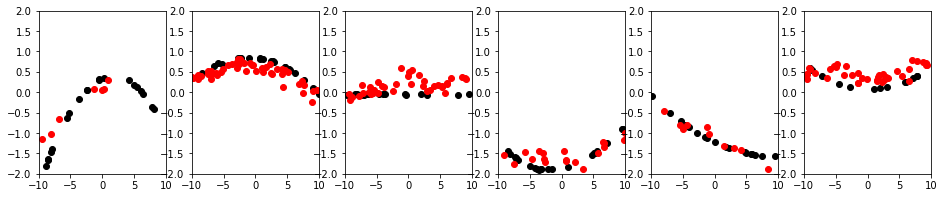

tensor(1481.5751, grad_fn=<AddBackward0>)


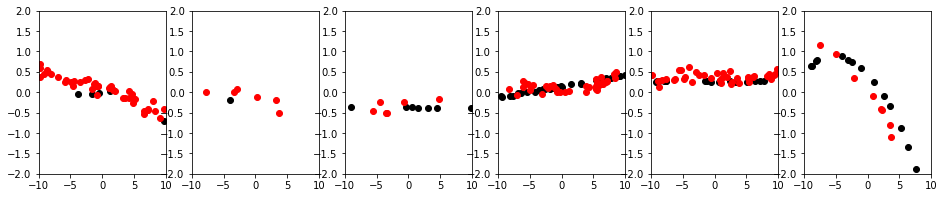

tensor(1475.6909, grad_fn=<AddBackward0>)


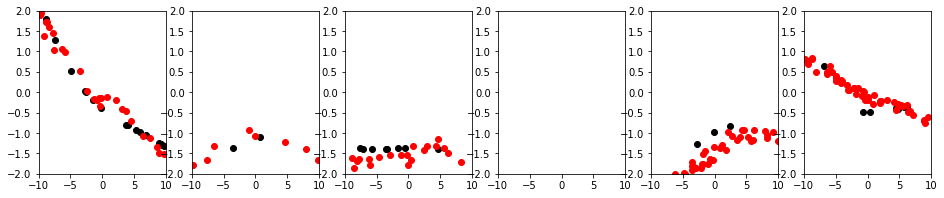

tensor(1410.2738, grad_fn=<AddBackward0>)


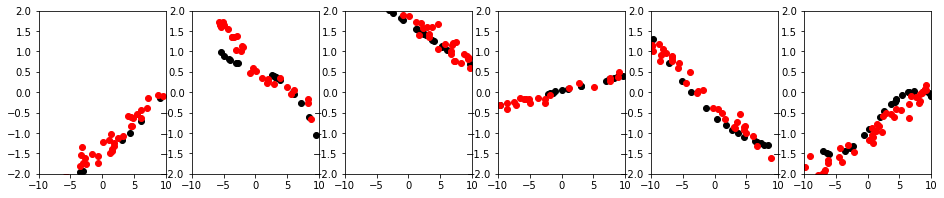

tensor(1448.4614, grad_fn=<AddBackward0>)


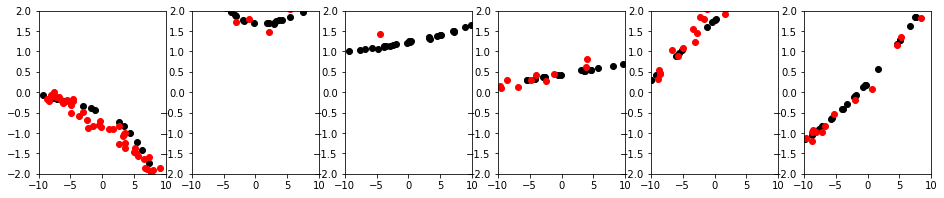

tensor(1259.2294, grad_fn=<AddBackward0>)


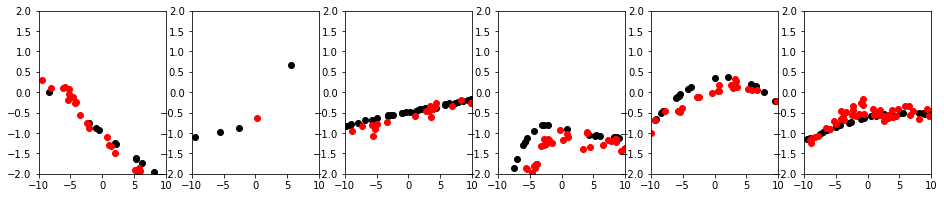

tensor(1363.9485, grad_fn=<AddBackward0>)


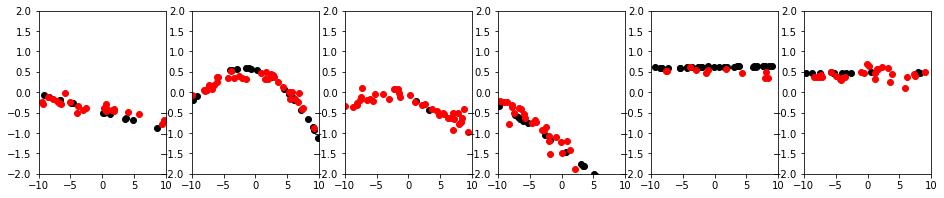

tensor(1473.5802, grad_fn=<AddBackward0>)


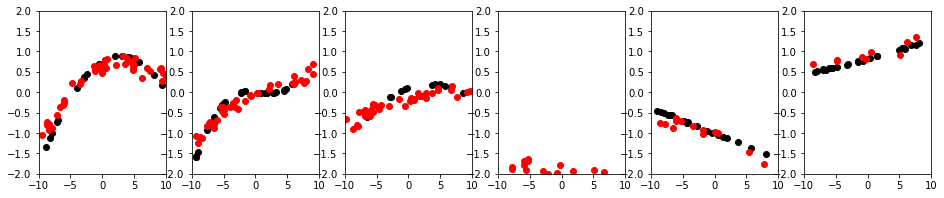

tensor(1431.4226, grad_fn=<AddBackward0>)


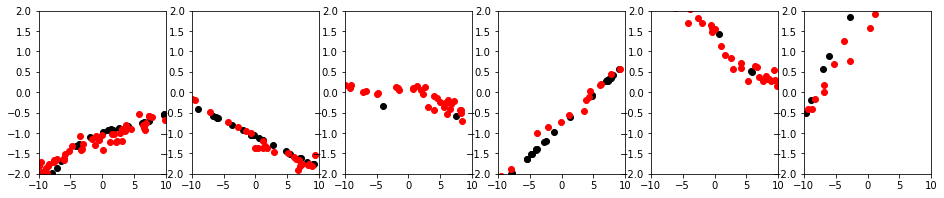

tensor(1181.0214, grad_fn=<AddBackward0>)


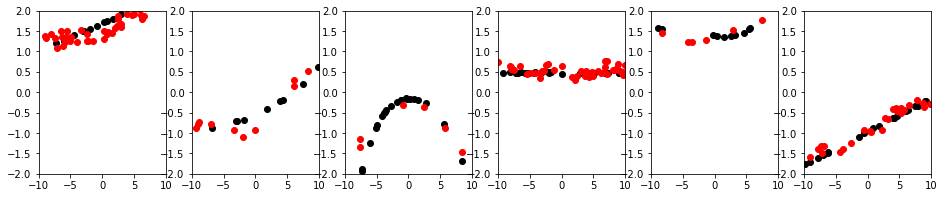

tensor(1422.7148, grad_fn=<AddBackward0>)


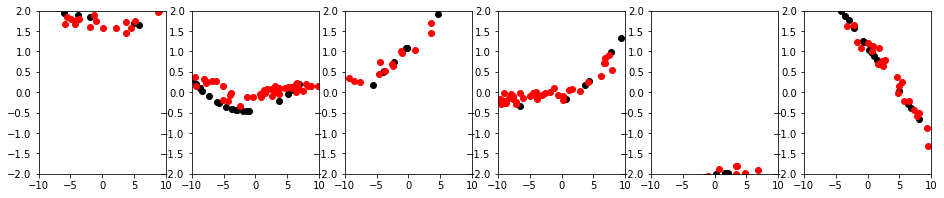

tensor(1424.6085, grad_fn=<AddBackward0>)


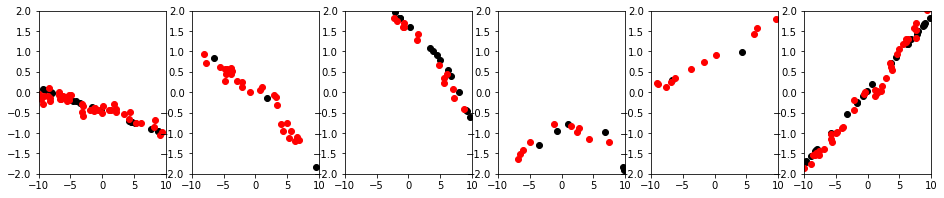

tensor(1235.7335, grad_fn=<AddBackward0>)


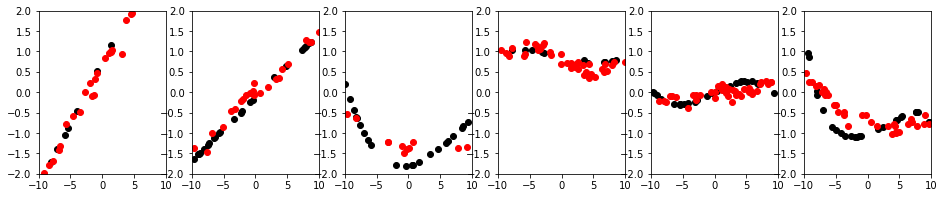

tensor(1337.1750, grad_fn=<AddBackward0>)


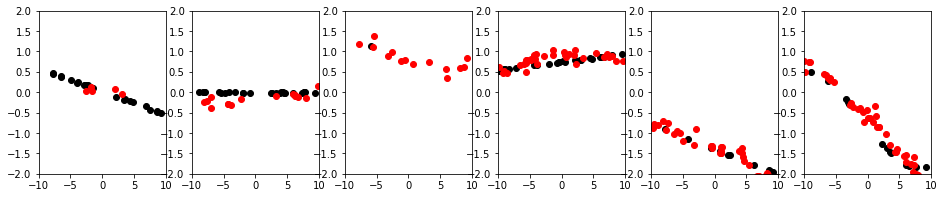

tensor(1512.5352, grad_fn=<AddBackward0>)


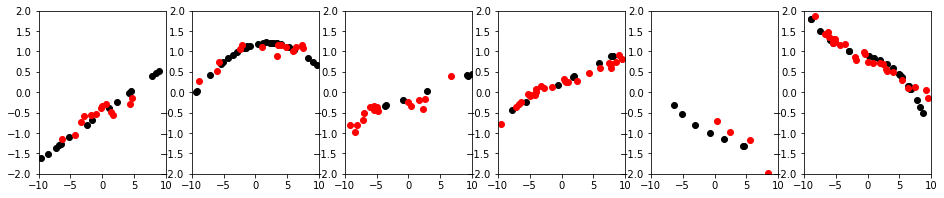

tensor(1260.3081, grad_fn=<AddBackward0>)


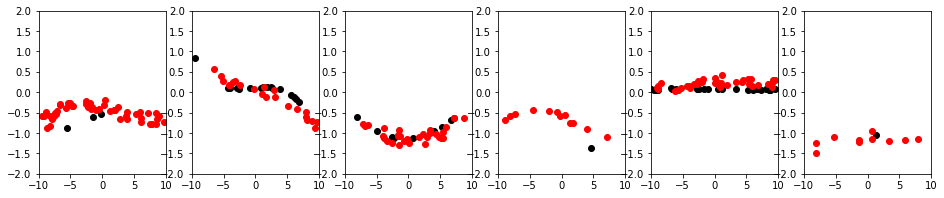

tensor(1250.8616, grad_fn=<AddBackward0>)


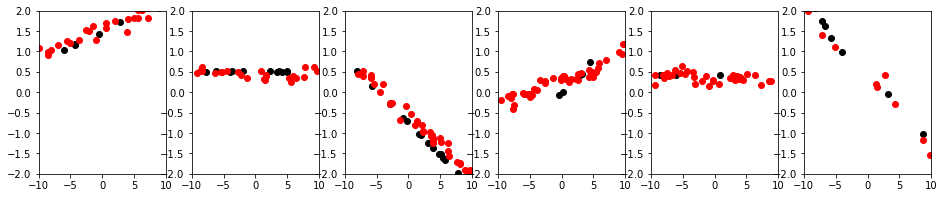

tensor(1104.4470, grad_fn=<AddBackward0>)


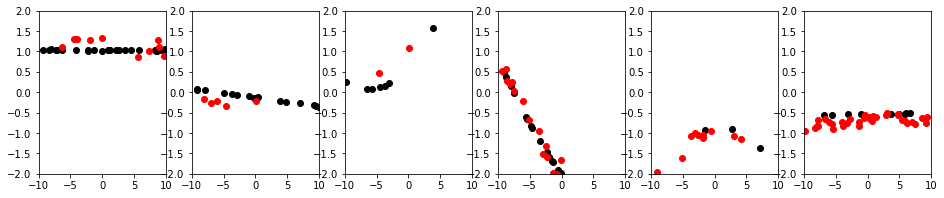

tensor(1279.1045, grad_fn=<AddBackward0>)


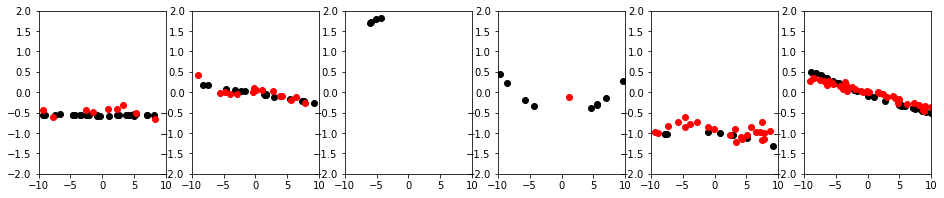

tensor(1258.7765, grad_fn=<AddBackward0>)


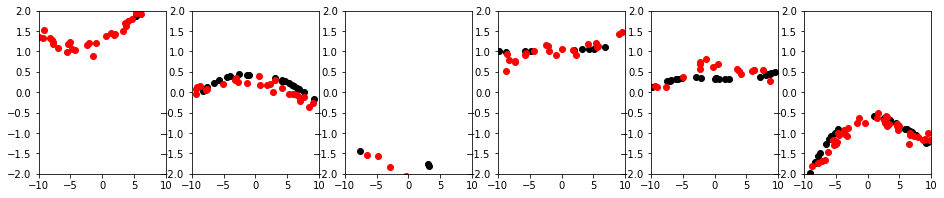

tensor(1092.9482, grad_fn=<AddBackward0>)


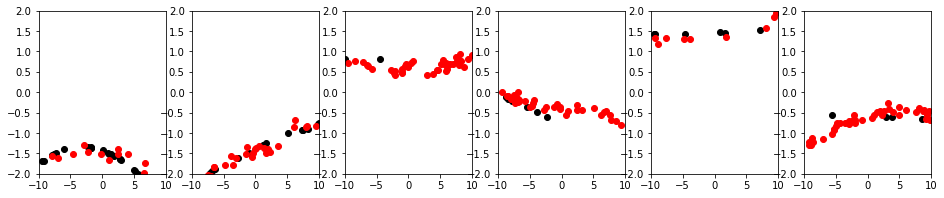

tensor(1239.1960, grad_fn=<AddBackward0>)


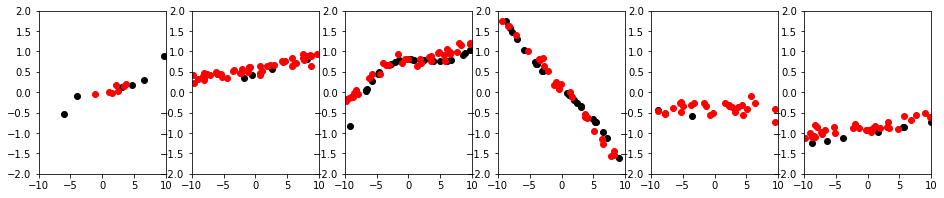

tensor(1474.8763, grad_fn=<AddBackward0>)


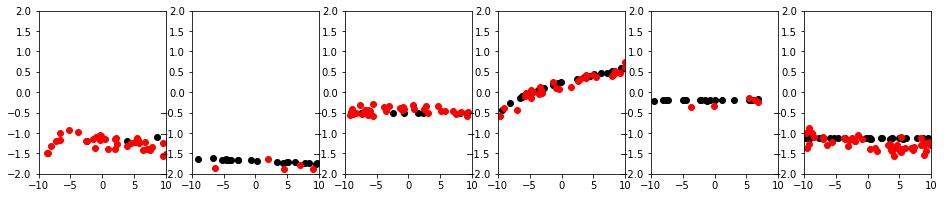

tensor(1346.4106, grad_fn=<AddBackward0>)


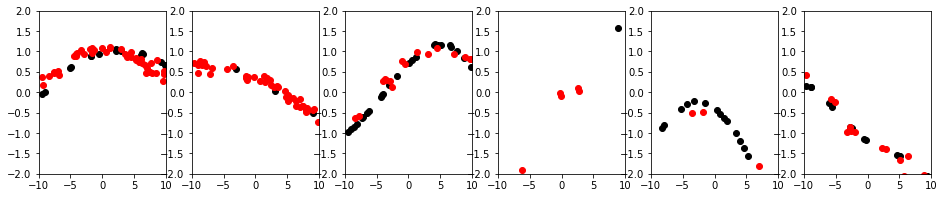

tensor(1160.1083, grad_fn=<AddBackward0>)


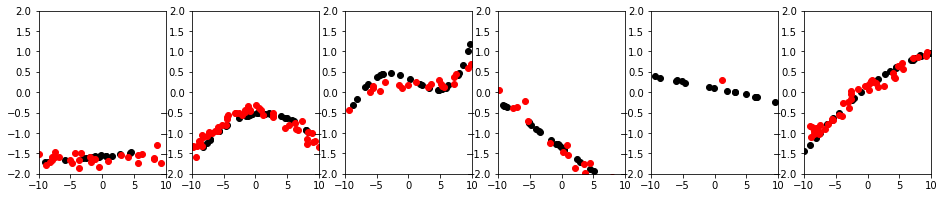

tensor(1045.4102, grad_fn=<AddBackward0>)


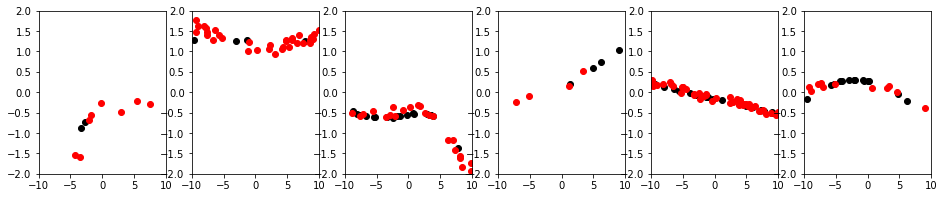

tensor(1164.0117, grad_fn=<AddBackward0>)


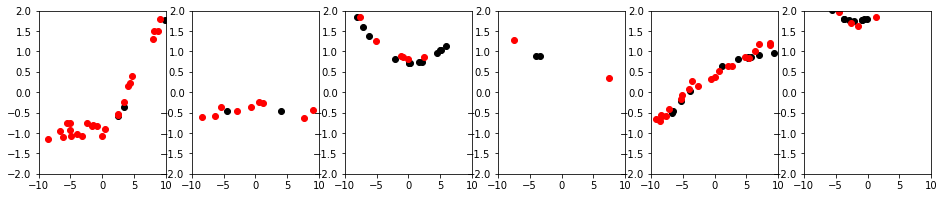

tensor(1125.1986, grad_fn=<AddBackward0>)


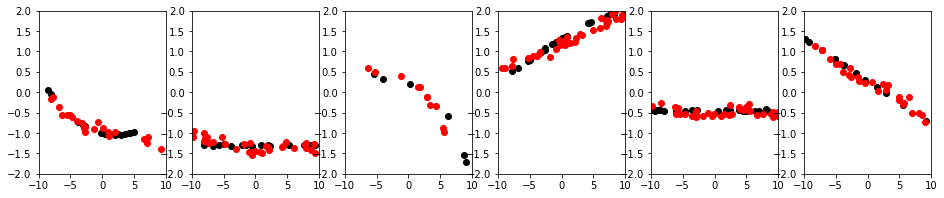

tensor(1180.1222, grad_fn=<AddBackward0>)


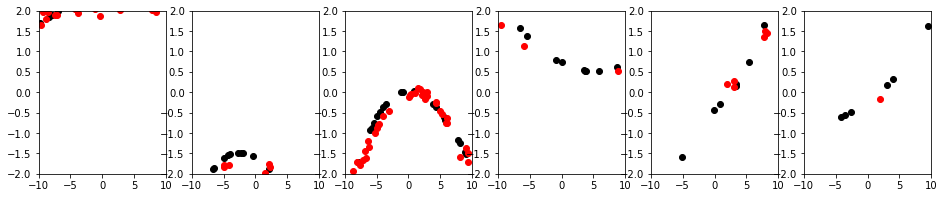

tensor(980.0706, grad_fn=<AddBackward0>)


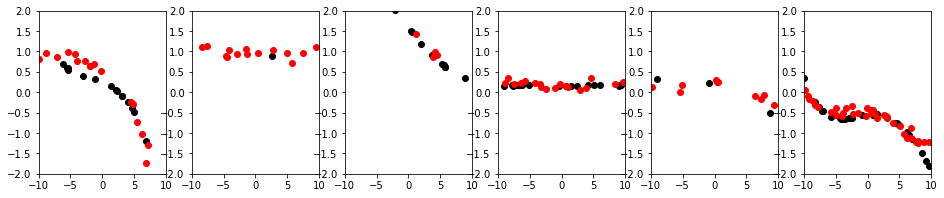

tensor(1097.6633, grad_fn=<AddBackward0>)


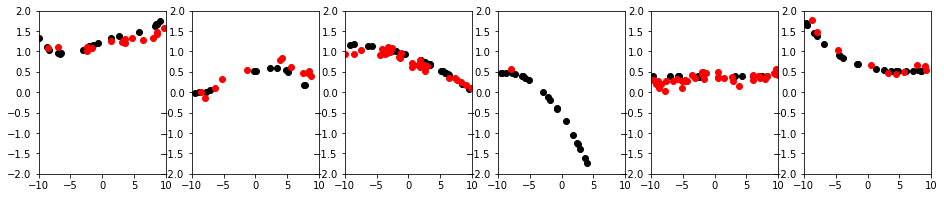

tensor(1148.9330, grad_fn=<AddBackward0>)


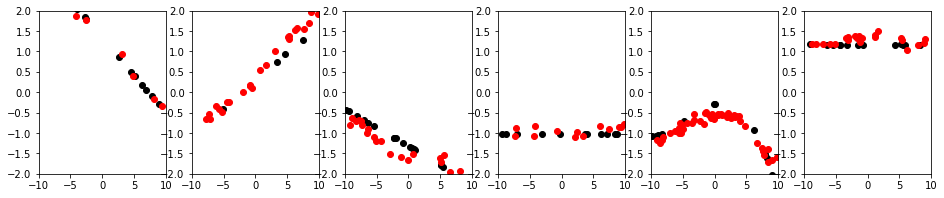

tensor(1223.7637, grad_fn=<AddBackward0>)


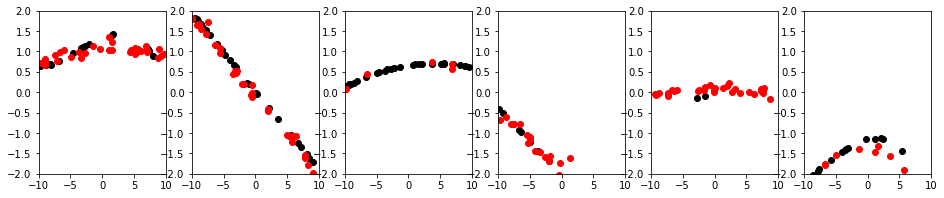

tensor(936.9889, grad_fn=<AddBackward0>)


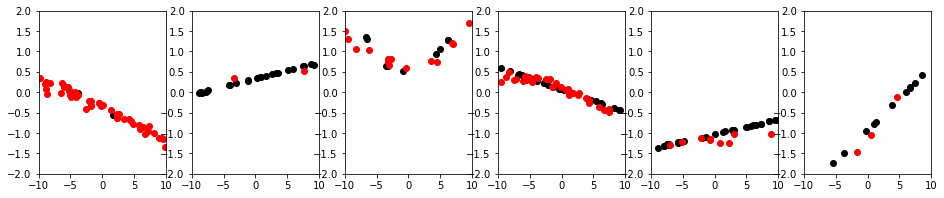

tensor(1046.0083, grad_fn=<AddBackward0>)


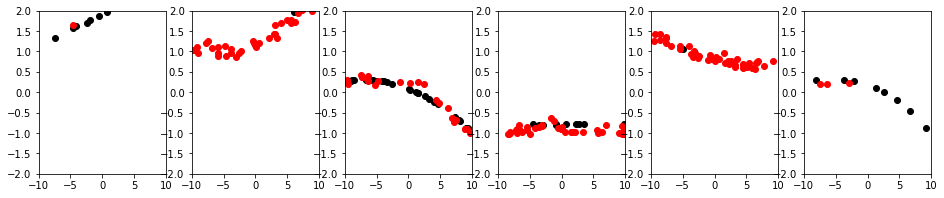

tensor(1037.8214, grad_fn=<AddBackward0>)


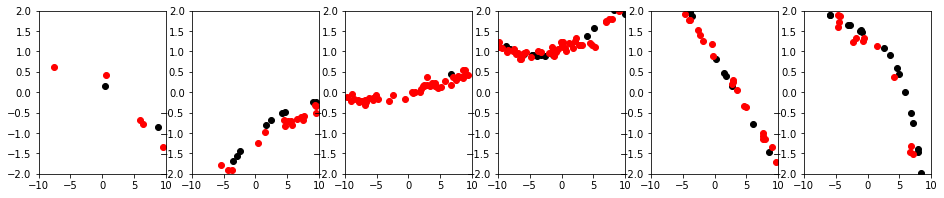

tensor(959.9595, grad_fn=<AddBackward0>)


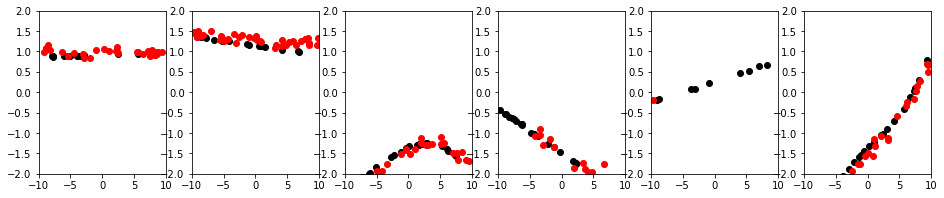

In [2]:
from network import AttentiveNeuralProcess

anp = AttentiveNeuralProcess(x_dim=1, y_dim=1, num_hidden=64)
optim = torch.optim.Adam(anp.parameters(), lr=1e-4)

for iteration in range(3000):
    y_pred, kl, loss = anp.forward(*generate_batch(64))
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if iteration % 50 == 0:
        print(loss)
        n_plots = 6
        fig, axes = plt.subplots(ncols=n_plots, figsize=(16, 3))
        Xcontext, Ycontext, Xtest, _ = generate_batch(n_plots)
        Ypred, _, _ = anp.forward(Xcontext, Ycontext, Xtest, None)
        for i, (x, y) in enumerate(zip(Xcontext, Ycontext)):
            x = x.view(-1).numpy()
            y = y.view(-1).numpy()
            axes[i].scatter(x, y, color='k')
        for i, (xt, yt) in enumerate(zip(Xtest, Ypred)):
            xt = xt.view(-1).numpy()
            yt = yt.view(-1).detach().numpy()
            axes[i].scatter(xt, yt, color='r')
            axes[i].set_xlim(-10, 10)
            axes[i].set_ylim(-2, 2)
        plt.show()

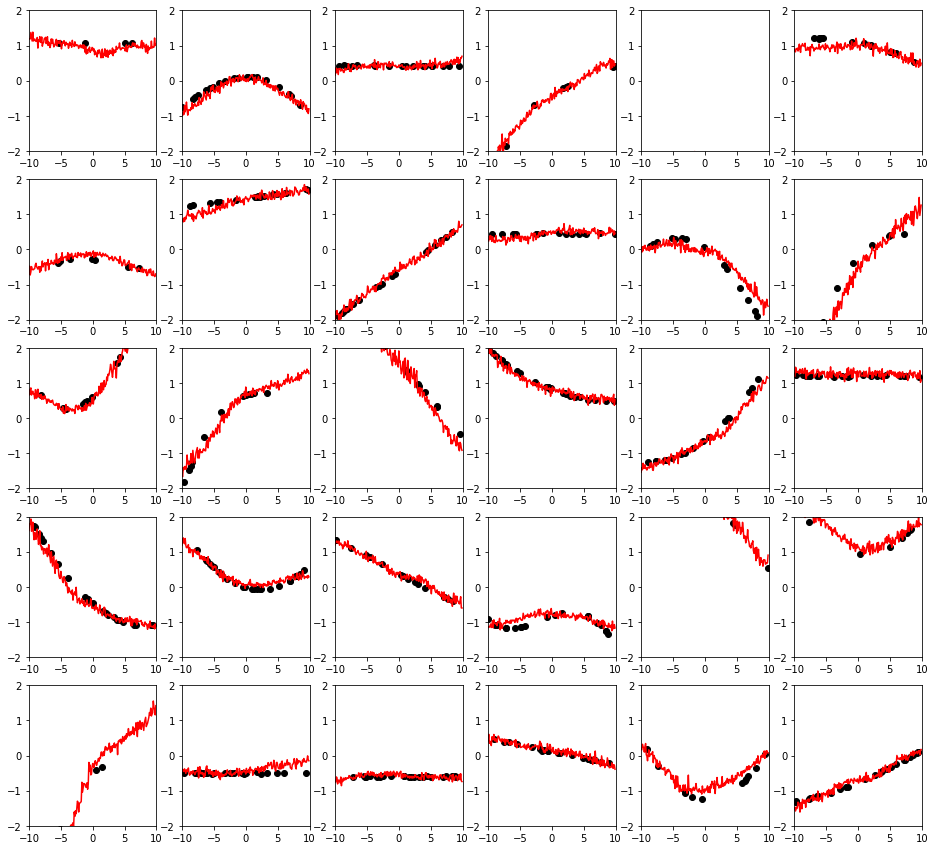

In [19]:
n_rows = 5
n_cols = 6
n_plots = n_rows*n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 3*n_rows))
axes = axes.reshape(-1)
Xcontext, Ycontext, _, _ = generate_batch(n_plots)
Xtest = torch.arange(-10., 10., 0.1).view(1, -1, 1).expand(len(Xtest), -1, -1)
Ypred, _, _ = anp.forward(Xcontext, Ycontext, Xtest, None)
for i, (x, y) in enumerate(zip(Xcontext, Ycontext)):
    x = x.view(-1).numpy()
    y = y.view(-1).numpy()
    axes[i].scatter(x, y, color='k')
for i, (xt, yt) in enumerate(zip(Xtest, Ypred)):
    xt = xt.view(-1).numpy()
    yt = yt.view(-1).detach().numpy()
    axes[i].plot(xt, yt, color='r')
    axes[i].set_xlim(-10, 10)
    axes[i].set_ylim(-2, 2)
plt.show()

## Plot another sample:

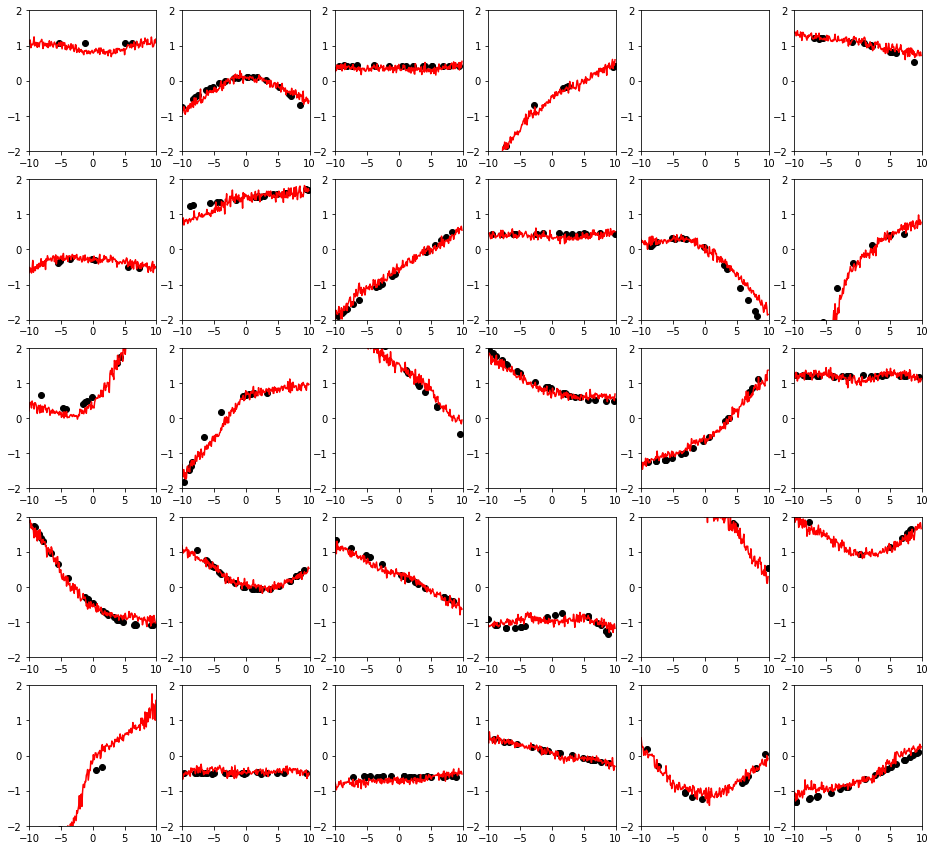

In [20]:
n_rows = 5
n_cols = 6
n_plots = n_rows*n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 3*n_rows))
axes = axes.reshape(-1)
Ypred, _, _ = anp.forward(Xcontext, Ycontext, Xtest, None)
for i, (x, y) in enumerate(zip(Xcontext, Ycontext)):
    x = x.view(-1).numpy()
    y = y.view(-1).numpy()
    axes[i].scatter(x, y, color='k')
for i, (xt, yt) in enumerate(zip(Xtest, Ypred)):
    xt = xt.view(-1).numpy()
    yt = yt.view(-1).detach().numpy()
    axes[i].plot(xt, yt, color='r')
    axes[i].set_xlim(-10, 10)
    axes[i].set_ylim(-2, 2)
plt.show()